In [1]:
import pandas as pd
import numpy as np  


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import sklearn


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import optuna

import xgboost as xgb


In [2]:
solar_train = pd.read_csv('../data/external/solar_train.csv')
solar_train.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475175023,9/29/2016 12:00:00 AM,08:50:23,634.99,61,30.46,41,14.96,6.75,06:13:00,18:13:00
1,1481799902,12/15/2016 12:00:00 AM,01:05:02,1.27,37,30.26,70,207.43,5.62,06:50:00,17:46:00
2,1478339417,11/4/2016 12:00:00 AM,23:50:17,1.21,47,30.49,33,168.20,5.62,06:25:00,17:47:00
3,1472887208,9/2/2016 12:00:00 AM,21:20:08,1.67,54,30.46,101,152.60,3.37,06:07:00,18:37:00
4,1478724901,11/9/2016 12:00:00 AM,10:55:01,839.78,62,30.47,36,291.95,7.87,06:28:00,17:45:00


In [3]:
sol_phys_train = pd.read_csv('../data/interim/solar_phys_train.csv')
sol_phys_train = sol_phys_train.drop('Unnamed: 0', axis=1)
sol_phys_train.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,634.99,289.26,4060.99,41,0.0416,3.02
1,1.27,275.93,4034.32,70,0.5762,2.51
2,1.21,281.48,4064.99,33,0.4672,2.51
3,1.67,285.37,4060.99,101,0.4239,1.51
4,839.78,289.82,4062.32,36,0.8110,3.52


In [4]:
sol_phys_train['Time'] =  pd.to_timedelta(solar_train['Time'])/ pd.to_timedelta(1, unit='D')

In [8]:
sol_phys_train['SunTime'] = (pd.to_timedelta(solar_train['TimeSunSet']) - pd.to_timedelta(solar_train['TimeSunRise']))/pd.to_timedelta(1, unit='D')

In [30]:
sol_phys_train['DayOfYear'] = solar_train['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofyear )

In [32]:
sol_phys_train['DayOfWeek'] = solar_train['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofweek)

In [33]:
sol_phys_train.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Time,SunTime,DayOfYear,DayOfWeek
0,634.99,289.26,4060.99,41,0.0416,3.02,0.368322,0.500000,273,3
1,1.27,275.93,4034.32,70,0.5762,2.51,0.045162,0.455556,350,3
2,1.21,281.48,4064.99,33,0.4672,2.51,0.993252,0.473611,309,4
3,1.67,285.37,4060.99,101,0.4239,1.51,0.888981,0.520833,246,4
4,839.78,289.82,4062.32,36,0.8110,3.52,0.454873,0.470139,314,2


In [34]:
X = sol_phys_train[[c for c in sol_phys_train if c != 'Radiation']].values
y = sol_phys_train[['Radiation']].values

In [35]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y,random_state=0, test_size=0.30)

In [36]:
def objective_xgb(trial):
# Invoke suggest methods of a Trial object to generate hyperparameters.

    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_val, label = y_val)

    param = {
        "silent": 1,
        "objective": 'reg:linear',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        'eval_metric': 'rmse'
    }

    if param["booster"] == "gbtree" or param["booster"] == "gblinear":
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000)        
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000) 
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    bst = xgb.train(param, dtrain)
    y_pred = bst.predict(dvalid)
 
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    
    
    return error # An objective value linked with the Trial object.

In [37]:
study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=300)
study_xgb.best_params

[I 2020-05-05 12:38:02,029] Finished trial#0 with value: 146014.86485827033 with parameters: {'booster': 'gblinear', 'lambda': 6.470955040971482e-08, 'alpha': 0.9582725321375919, 'subsample': 0.0002124712044192236, 'n_trees': 638, 'max_depth': 48, 'eta': 1.472066468553505e-06, 'gamma': 6.789868003842498e-08, 'grow_policy': 'lossguide'}. Best is trial#0 with value: 146014.86485827033.
[I 2020-05-05 12:38:02,713] Finished trial#1 with value: 122224.93536365769 with parameters: {'booster': 'gbtree', 'lambda': 0.00012235166532872707, 'alpha': 0.2320512426448147, 'subsample': 0.07807189100508312, 'n_trees': 224, 'max_depth': 16, 'eta': 0.6976661198256916, 'gamma': 0.013237432503006467, 'grow_policy': 'depthwise'}. Best is trial#1 with value: 122224.93536365769.
[I 2020-05-05 12:38:03,240] Finished trial#2 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 1.243669977818199e-08, 'alpha': 1.5928388435810925e-08, 'max_depth': 50, 'subsample': 2.4963748531756174e-07, '

[I 2020-05-05 12:38:14,351] Finished trial#20 with value: 9516.892946076336 with parameters: {'booster': 'dart', 'lambda': 0.0028592543695031124, 'alpha': 1.035767230618663e-07, 'max_depth': 64, 'subsample': 0.45452980460158343, 'n_trees': 905, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3775290211863951e-08, 'skip_drop': 0.5199837070453841}. Best is trial#15 with value: 8421.947193458249.
[I 2020-05-05 12:38:15,454] Finished trial#21 with value: 13105.328095000577 with parameters: {'booster': 'dart', 'lambda': 0.004377929461148241, 'alpha': 9.146857785905103e-08, 'max_depth': 61, 'subsample': 0.19366428138113556, 'n_trees': 875, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4834029264911627e-08, 'skip_drop': 4.2025735540196385e-07}. Best is trial#15 with value: 8421.947193458249.
[I 2020-05-05 12:38:17,155] Finished trial#22 with value: 8609.409175260836 with parameters: {'booster': 'dart', 'lambda': 0.0005650536169681388, 'alpha': 3.3

[I 2020-05-05 12:38:36,329] Finished trial#39 with value: 45795.75109423588 with parameters: {'booster': 'gbtree', 'lambda': 1.0381004633213221e-08, 'alpha': 3.945703935867846e-08, 'subsample': 0.0027736632533057197, 'n_trees': 439, 'max_depth': 24, 'eta': 0.41509618595245756, 'gamma': 8.086442703279434e-05, 'grow_policy': 'lossguide'}. Best is trial#31 with value: 8387.929475949699.
[I 2020-05-05 12:38:36,815] Finished trial#40 with value: 73682.67374552938 with parameters: {'booster': 'dart', 'lambda': 3.603152084337833e-08, 'alpha': 2.8095728564794547e-07, 'max_depth': 32, 'subsample': 0.0003235091189434191, 'n_trees': 62, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0860854832832647e-05, 'skip_drop': 0.0028623309068095326}. Best is trial#31 with value: 8387.929475949699.
[I 2020-05-05 12:38:38,999] Finished trial#41 with value: 10208.26402386636 with parameters: {'booster': 'dart', 'lambda': 0.00029425501497347455, 'alpha': 7.675644032944312e-07, 'max_depth

[I 2020-05-05 12:38:58,236] Finished trial#58 with value: 8630.150822656966 with parameters: {'booster': 'dart', 'lambda': 0.04358266380952906, 'alpha': 2.4037697760869727e-05, 'max_depth': 33, 'subsample': 0.5529475424357435, 'n_trees': 428, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0605017249909853e-08, 'skip_drop': 1.1010649313554743e-05}. Best is trial#31 with value: 8387.929475949699.
[I 2020-05-05 12:38:58,773] Finished trial#59 with value: 145979.25710618054 with parameters: {'booster': 'gbtree', 'lambda': 0.19854018397476525, 'alpha': 2.6543127850441456e-05, 'subsample': 0.020040858432440502, 'n_trees': 424, 'max_depth': 33, 'eta': 1.8863107553803973e-05, 'gamma': 0.001771472163988617, 'grow_policy': 'lossguide'}. Best is trial#31 with value: 8387.929475949699.
[I 2020-05-05 12:38:59,579] Finished trial#60 with value: 15644.52932669306 with parameters: {'booster': 'dart', 'lambda': 0.0017716394775327306, 'alpha': 9.401753068935883e-06, 'max_depth': 2

[I 2020-05-05 12:39:16,806] Finished trial#77 with value: 100925.07565095546 with parameters: {'booster': 'gblinear', 'lambda': 0.12320717306238393, 'alpha': 0.008436266258948588, 'subsample': 0.3897651942793878, 'n_trees': 607, 'max_depth': 15, 'eta': 0.09529754207698124, 'gamma': 0.22106176945608955, 'grow_policy': 'lossguide'}. Best is trial#68 with value: 7995.769785845904.
[I 2020-05-05 12:39:17,433] Finished trial#78 with value: 15319.68690227706 with parameters: {'booster': 'dart', 'lambda': 0.7297308704921449, 'alpha': 0.07895250769594389, 'max_depth': 12, 'subsample': 0.055156153325443574, 'n_trees': 656, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000732079907470446, 'skip_drop': 1.557016928850358e-07}. Best is trial#68 with value: 7995.769785845904.
[I 2020-05-05 12:39:18,093] Finished trial#79 with value: 145965.66959575764 with parameters: {'booster': 'gbtree', 'lambda': 0.2651608042796472, 'alpha': 0.0017279317878672866, 'subsample': 0.9304078918

[I 2020-05-05 12:39:28,902] Finished trial#96 with value: 8482.954359146934 with parameters: {'booster': 'dart', 'lambda': 0.9408955002621903, 'alpha': 0.2956097050250203, 'max_depth': 11, 'subsample': 0.42903988233787, 'n_trees': 595, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.004507490222443952, 'skip_drop': 2.0487389098683506e-08}. Best is trial#95 with value: 7987.705354706747.
[I 2020-05-05 12:39:29,341] Finished trial#97 with value: 41320.72366864918 with parameters: {'booster': 'dart', 'lambda': 0.20678399337054085, 'alpha': 0.4858644642927853, 'max_depth': 12, 'subsample': 0.0008102861457106595, 'n_trees': 919, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08381542785507202, 'skip_drop': 6.199426689481244e-08}. Best is trial#95 with value: 7987.705354706747.
[I 2020-05-05 12:39:29,923] Finished trial#98 with value: 8160.204506194574 with parameters: {'booster': 'dart', 'lambda': 0.638280437915764, 'alpha': 0.02366998624238649, 

[I 2020-05-05 12:39:41,361] Finished trial#115 with value: 10108.335771960375 with parameters: {'booster': 'dart', 'lambda': 0.17365231136157439, 'alpha': 0.0015547379246208571, 'max_depth': 15, 'subsample': 0.32274049451048, 'n_trees': 564, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00046974399607132607, 'skip_drop': 3.965432146729236e-08}. Best is trial#111 with value: 7791.695747426019.
[I 2020-05-05 12:39:41,943] Finished trial#116 with value: 8030.9675765564825 with parameters: {'booster': 'dart', 'lambda': 0.6539030877337234, 'alpha': 0.012464435491719699, 'max_depth': 12, 'subsample': 0.7230246786515107, 'n_trees': 500, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00220627829748747, 'skip_drop': 4.778220758801265e-08}. Best is trial#111 with value: 7791.695747426019.
[I 2020-05-05 12:39:42,519] Finished trial#117 with value: 12642.332134496624 with parameters: {'booster': 'dart', 'lambda': 0.059957338645664895, 'alpha': 0.010153983

[I 2020-05-05 12:39:53,732] Finished trial#134 with value: 7935.803754859147 with parameters: {'booster': 'dart', 'lambda': 0.5967783170713951, 'alpha': 0.12157289714770873, 'max_depth': 9, 'subsample': 0.994474639085861, 'n_trees': 461, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0011463820431962186, 'skip_drop': 7.340997225353139e-08}. Best is trial#133 with value: 7629.659526973401.
[I 2020-05-05 12:39:54,274] Finished trial#135 with value: 11355.923909818368 with parameters: {'booster': 'dart', 'lambda': 0.5551728981454307, 'alpha': 0.12091985845931275, 'max_depth': 5, 'subsample': 0.9930273480031274, 'n_trees': 467, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0009392304353974528, 'skip_drop': 6.491054446880802e-08}. Best is trial#133 with value: 7629.659526973401.
[I 2020-05-05 12:39:54,869] Finished trial#136 with value: 8059.660874270929 with parameters: {'booster': 'dart', 'lambda': 0.9335279558362609, 'alpha': 0.3240552790463285,

[I 2020-05-05 12:40:04,592] Finished trial#153 with value: 7917.997759241619 with parameters: {'booster': 'dart', 'lambda': 0.9630817635152155, 'alpha': 0.10406199378239427, 'max_depth': 8, 'subsample': 0.9782718280673374, 'n_trees': 340, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.000344008957945439, 'skip_drop': 4.358795927107933e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:05,285] Finished trial#154 with value: 8417.626034321353 with parameters: {'booster': 'dart', 'lambda': 0.9676436016495953, 'alpha': 0.1045490711536281, 'max_depth': 7, 'subsample': 0.9612652335570696, 'n_trees': 342, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0003280182125470285, 'skip_drop': 3.811951285821133e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:05,870] Finished trial#155 with value: 8788.076617888886 with parameters: {'booster': 'dart', 'lambda': 0.38695856472853507, 'alpha': 0.584047058322358, '

[I 2020-05-05 12:40:16,469] Finished trial#172 with value: 8071.875743788191 with parameters: {'booster': 'dart', 'lambda': 0.9968701395984476, 'alpha': 0.2188131181606382, 'max_depth': 11, 'subsample': 0.933630520230225, 'n_trees': 480, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0017914168097807547, 'skip_drop': 1.5281731814544222e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:17,018] Finished trial#173 with value: 7852.117808463539 with parameters: {'booster': 'dart', 'lambda': 0.7389309342348079, 'alpha': 0.10411840550888402, 'max_depth': 8, 'subsample': 0.9909429065739046, 'n_trees': 433, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0008617221048979528, 'skip_drop': 2.1374176861003068e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:17,542] Finished trial#174 with value: 9594.103167880874 with parameters: {'booster': 'dart', 'lambda': 0.3457593222679364, 'alpha': 0.12817755268009767,

[I 2020-05-05 12:40:28,148] Finished trial#191 with value: 7832.249267104631 with parameters: {'booster': 'dart', 'lambda': 0.5358263384171851, 'alpha': 0.036674894850181654, 'max_depth': 11, 'subsample': 0.9432436985778351, 'n_trees': 505, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00036383846443085804, 'skip_drop': 5.1353140057612245e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:28,701] Finished trial#192 with value: 7865.024520755626 with parameters: {'booster': 'dart', 'lambda': 0.4985286190800665, 'alpha': 0.027595144178037358, 'max_depth': 11, 'subsample': 0.8938919089228148, 'n_trees': 501, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00029632338706725626, 'skip_drop': 4.5044629770089535e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:29,269] Finished trial#193 with value: 7727.234793304374 with parameters: {'booster': 'dart', 'lambda': 0.6337014734926147, 'alpha': 0.02336832543

[I 2020-05-05 12:40:40,031] Finished trial#210 with value: 7861.126307441684 with parameters: {'booster': 'dart', 'lambda': 0.5277349813621959, 'alpha': 0.04477004508649381, 'max_depth': 12, 'subsample': 0.6825599180859452, 'n_trees': 465, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00023318994659896742, 'skip_drop': 2.1355787353498336e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:40,519] Finished trial#211 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 0.5120684235173524, 'alpha': 0.03989763180324861, 'max_depth': 12, 'subsample': 1.2192224595219996e-08, 'n_trees': 466, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0002192683520959072, 'skip_drop': 2.8260882536012186e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:41,142] Finished trial#212 with value: 26026.29218407572 with parameters: {'booster': 'dart', 'lambda': 0.6158279055699106, 'alpha': 0.0323657045

[I 2020-05-05 12:40:53,236] Finished trial#229 with value: 100464.92835360767 with parameters: {'booster': 'gblinear', 'lambda': 0.6051011090556719, 'alpha': 0.018820165430000757, 'subsample': 0.6856317684923968, 'n_trees': 443, 'max_depth': 9, 'eta': 0.1642336888161239, 'gamma': 0.6236716599641913, 'grow_policy': 'lossguide'}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:53,789] Finished trial#230 with value: 8699.790674722337 with parameters: {'booster': 'dart', 'lambda': 0.2901029892771475, 'alpha': 0.010872585863893378, 'max_depth': 7, 'subsample': 0.7437474254929826, 'n_trees': 475, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.737143045592354e-05, 'skip_drop': 2.5607152246398097e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:40:54,430] Finished trial#231 with value: 8046.955012560559 with parameters: {'booster': 'dart', 'lambda': 0.4811695597130907, 'alpha': 0.02670736511250517, 'max_depth': 11, 'subsample': 0.

[I 2020-05-05 12:41:04,387] Finished trial#248 with value: 92062.49796374225 with parameters: {'booster': 'gbtree', 'lambda': 0.5649359040690582, 'alpha': 0.0072189729210826396, 'subsample': 0.6315100182226592, 'n_trees': 482, 'max_depth': 11, 'eta': 0.025529521151688717, 'gamma': 0.5374489475250828, 'grow_policy': 'lossguide'}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:04,928] Finished trial#249 with value: 9288.054735408032 with parameters: {'booster': 'dart', 'lambda': 0.34618937897041757, 'alpha': 0.004039010755844215, 'max_depth': 7, 'subsample': 0.39475460507248594, 'n_trees': 411, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.2398006852596413e-05, 'skip_drop': 5.322825281484566e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:05,544] Finished trial#250 with value: 7680.166674120849 with parameters: {'booster': 'dart', 'lambda': 0.15614413270723534, 'alpha': 0.010340815909885996, 'max_depth': 9, 'subsample'

[I 2020-05-05 12:41:16,131] Finished trial#267 with value: 8546.850927173848 with parameters: {'booster': 'dart', 'lambda': 0.14073611769086167, 'alpha': 0.01226671641000042, 'max_depth': 9, 'subsample': 0.6844898756532172, 'n_trees': 424, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.430098606813078e-06, 'skip_drop': 1.0510259099148111e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:16,705] Finished trial#268 with value: 8775.78057449922 with parameters: {'booster': 'dart', 'lambda': 0.3143342875625485, 'alpha': 0.0211725139672785, 'max_depth': 10, 'subsample': 0.41500904080243783, 'n_trees': 448, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.4649923467526873e-06, 'skip_drop': 4.032249973108425e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:17,200] Finished trial#269 with value: 11215.699664326099 with parameters: {'booster': 'dart', 'lambda': 0.19397469888234298, 'alpha': 0.00573655958158

[I 2020-05-05 12:41:29,212] Finished trial#286 with value: 7806.331567172946 with parameters: {'booster': 'dart', 'lambda': 0.1847921387812998, 'alpha': 0.00582744983353405, 'max_depth': 10, 'subsample': 0.9737301497039057, 'n_trees': 512, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.476762368445951e-05, 'skip_drop': 2.6749711916132838e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:31,567] Finished trial#287 with value: 9269.060147210841 with parameters: {'booster': 'dart', 'lambda': 0.5043739175750327, 'alpha': 0.03094845526559288, 'max_depth': 57, 'subsample': 0.48509034665695866, 'n_trees': 392, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2369076657681921e-05, 'skip_drop': 1.346616714699374e-08}. Best is trial#151 with value: 7508.221764851354.
[I 2020-05-05 12:41:32,904] Finished trial#288 with value: 8819.650371971005 with parameters: {'booster': 'dart', 'lambda': 0.11331381556279632, 'alpha': 0.0037697308038

{'booster': 'dart',
 'lambda': 0.9216923846598017,
 'alpha': 0.3185974838264482,
 'max_depth': 10,
 'subsample': 0.9181809624853065,
 'n_trees': 417,
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.0006506814811623782,
 'skip_drop': 1.5198290892908495e-08}

In [38]:
xgb_params = study_xgb.best_params
xgb_params

{'booster': 'dart',
 'lambda': 0.9216923846598017,
 'alpha': 0.3185974838264482,
 'max_depth': 10,
 'subsample': 0.9181809624853065,
 'n_trees': 417,
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.0006506814811623782,
 'skip_drop': 1.5198290892908495e-08}

In [39]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_val)

[0]	train-rmse:272.65	test-rmse:275.491


<Figure size 1080x720 with 0 Axes>

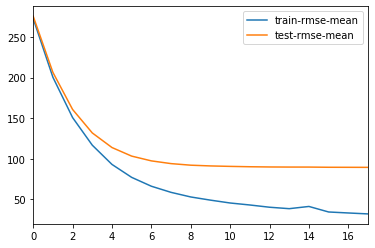

In [41]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=200, show_stdv=False)

plt.figure(figsize=(15,10))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [42]:
cv_output

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,272.649688,1.590017,275.490580,3.350260
1,200.378143,1.111668,206.362711,3.411676
2,150.692439,1.065434,160.680283,3.205766
3,116.685557,1.033576,131.768018,2.756785
4,92.972514,1.018746,113.781863,2.655879
5,77.031487,0.624954,103.216238,2.610878
6,66.118121,0.736924,97.352956,2.216241
7,58.568297,1.192953,93.979439,2.094846
8,52.896281,0.783134,92.035866,2.001760
9,48.989304,0.810241,91.122945,1.905076


In [43]:
num_boost_rounds = len(cv_output)
print(num_boost_rounds)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

18


In [44]:
sol_phys_test = pd.read_csv('../data/interim/solar_phys_test.csv')
sol_phys_test = sol_phys_test.drop('Unnamed: 0', axis=1)
sol_phys_test.head()

,id,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,0,288.15,4062.32,44,0.8685,1.51
1,1,288.15,4063.65,83,0.1056,3.02
2,2,281.48,4051.66,78,0.5934,2.51
3,3,280.37,4052.99,98,0.4906,2.01
4,4,280.37,4052.99,34,0.4886,3.02


In [45]:
solar_original_test = pd.read_csv('../data/external/solar_test.csv')
solar_original_test.head()

,id,UNIXTime,Data,Time,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,0,1478720107,11/9/2016 12:00:00 AM,09:35:07,59,30.47,44,312.67,3.37,06:28:00,17:45:00
1,1,1474063503,9/16/2016 12:00:00 AM,12:05:03,59,30.48,83,38.01,6.75,06:10:00,18:25:00
2,2,1476109221,10/10/2016 12:00:00 AM,04:20:21,47,30.39,78,213.62,5.62,06:16:00,18:03:00
3,3,1481475056,12/11/2016 12:00:00 AM,06:50:56,45,30.40,98,176.63,4.50,06:47:00,17:44:00
4,4,1477493117,10/26/2016 12:00:00 AM,04:45:17,45,30.40,34,175.89,6.75,06:21:00,17:52:00


In [46]:

sol_phys_test['Time'] =  pd.to_timedelta(solar_original_test['Time'])/ pd.to_timedelta(1, unit='D')
sol_phys_test['SunTime'] = (pd.to_timedelta(solar_original_test['TimeSunSet']) -pd.to_timedelta(solar_train['TimeSunRise']))/pd.to_timedelta(1, unit='D')
sol_phys_test['DayOfYear'] = solar_original_test['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofyear )
sol_phys_test['DayOfWeek'] = solar_original_test['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofweek)


In [47]:
X_t = sol_phys_test.drop('id',axis=1)

In [48]:
dvalidation = xgb.DMatrix(X_t.values)
predic_testf = model.predict(dvalidation)
submission7 = pd.DataFrame()
submission7['id'] = sol_phys_test['id']
submission7['Radiation'] = predic_testf

In [51]:
submission7[submission7['Radiation']<0].shape

(266, 2)

In [52]:
submission7['Radiation'] = submission7['Radiation'].apply(lambda x: x if x >= 0 else 0)
submission7.describe()

,id,Radiation
count,8172.000000,8172.000000
mean,4085.500000,205.642868
std,2359.197533,296.907300
min,0.000000,0.000000
25%,2042.750000,1.546704
50%,4085.500000,11.426309
75%,6128.250000,380.486732
max,8171.000000,1076.958862


In [53]:
submission7.to_csv('../data/processed/submission7.csv')

In [54]:
def objective_rm(trial):
# Invoke suggest methods of a Trial object to generate hyperparameters.

    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 64)
    rf_max_estimators = trial.suggest_int('n_estimators', 1, 3000)
        
    
    model = RandomForestRegressor(max_depth=rf_max_depth, criterion='mse', n_estimators = rf_max_estimators)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    
    
    return error # An objective value linked with the Trial object.

In [55]:
study_rm = optuna.create_study()
study_rm.optimize(objective_rm, n_trials=100)
study_rm.best_params

/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 12:54:42,727] Finished trial#0 with value: 6862.5082999443375 with parameters: {'rf_max_depth': 36, 'n_estimators': 126}. Best is trial#0 with value: 6862.5082999443375.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 12:56:19,218] Finished trial#1 with value: 6839.089965040277 with parameters: {'rf_max_depth': 60, 'n_estimators': 1102}. Best is trial#1 with value: 6839.089965040277.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the

[I 2020-05-05 13:29:18,406] Finished trial#19 with value: 6831.794692330694 with parameters: {'rf_max_depth': 30, 'n_estimators': 1026}. Best is trial#7 with value: 6813.6170331802705.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 13:29:46,941] Finished trial#20 with value: 7012.037003629952 with parameters: {'rf_max_depth': 14, 'n_estimators': 426}. Best is trial#7 with value: 6813.6170331802705.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 13:31:42,316] Finished trial#21 with value: 6846.671171452835 with parameters: {'rf_max_depth': 21, 'n_estimators': 1338}. Best is trial#7 with value: 6813.6

[I 2020-05-05 13:58:28,287] Finished trial#39 with value: 6842.448774440807 with parameters: {'rf_max_depth': 60, 'n_estimators': 460}. Best is trial#36 with value: 6802.802043879693.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 13:58:46,219] Finished trial#40 with value: 6939.690933579655 with parameters: {'rf_max_depth': 54, 'n_estimators': 179}. Best is trial#36 with value: 6802.802043879693.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 13:59:38,567] Finished trial#41 with value: 6854.214894656027 with parameters: {'rf_max_depth': 64, 'n_estimators': 549}. Best is trial#36 with value: 6802.80

[I 2020-05-05 14:19:45,404] Finished trial#59 with value: 6847.777248371857 with parameters: {'rf_max_depth': 47, 'n_estimators': 313}. Best is trial#56 with value: 6758.900318092367.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 14:24:09,794] Finished trial#60 with value: 6843.365827191679 with parameters: {'rf_max_depth': 33, 'n_estimators': 2927}. Best is trial#56 with value: 6758.900318092367.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 14:25:10,216] Finished trial#61 with value: 6823.666072568912 with parameters: {'rf_max_depth': 29, 'n_estimators': 794}. Best is trial#56 with value: 6758.9

[I 2020-05-05 14:43:55,641] Finished trial#79 with value: 6824.8914426143665 with parameters: {'rf_max_depth': 48, 'n_estimators': 1263}. Best is trial#56 with value: 6758.900318092367.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 14:45:09,513] Finished trial#80 with value: 6867.781852498144 with parameters: {'rf_max_depth': 45, 'n_estimators': 901}. Best is trial#56 with value: 6758.900318092367.
/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2020-05-05 14:46:11,073] Finished trial#81 with value: 6830.545265275731 with parameters: {'rf_max_depth': 38, 'n_estimators': 693}. Best is trial#56 with value: 6758.

[I 2020-05-05 15:16:37,874] Finished trial#99 with value: 6836.05307812309 with parameters: {'rf_max_depth': 34, 'n_estimators': 615}. Best is trial#56 with value: 6758.900318092367.


{'rf_max_depth': 37, 'n_estimators': 145}

In [56]:
study_rm_params = study_rm.best_params
study_rm_params

{'rf_max_depth': 37, 'n_estimators': 145}

In [58]:
model = RandomForestRegressor(max_depth=37, criterion='mse', n_estimators = 145)
model.fit(X_train, y_train)

/home/miguel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=37, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=145, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [60]:
predict = model.predict(X_val)
np.sqrt(mean_squared_error(predict, y_val))

83.48416760884876

In [61]:
sol_phys_test = pd.read_csv('../data/interim/solar_phys_test.csv')
sol_phys_test = sol_phys_test.drop('Unnamed: 0', axis=1)
sol_phys_test.head()

,id,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,0,288.15,4062.32,44,0.8685,1.51
1,1,288.15,4063.65,83,0.1056,3.02
2,2,281.48,4051.66,78,0.5934,2.51
3,3,280.37,4052.99,98,0.4906,2.01
4,4,280.37,4052.99,34,0.4886,3.02


In [62]:
solar_original_test = pd.read_csv('../data/external/solar_test.csv')
solar_original_test.head()

,id,UNIXTime,Data,Time,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,0,1478720107,11/9/2016 12:00:00 AM,09:35:07,59,30.47,44,312.67,3.37,06:28:00,17:45:00
1,1,1474063503,9/16/2016 12:00:00 AM,12:05:03,59,30.48,83,38.01,6.75,06:10:00,18:25:00
2,2,1476109221,10/10/2016 12:00:00 AM,04:20:21,47,30.39,78,213.62,5.62,06:16:00,18:03:00
3,3,1481475056,12/11/2016 12:00:00 AM,06:50:56,45,30.40,98,176.63,4.50,06:47:00,17:44:00
4,4,1477493117,10/26/2016 12:00:00 AM,04:45:17,45,30.40,34,175.89,6.75,06:21:00,17:52:00


In [63]:

sol_phys_test['Time'] =  pd.to_timedelta(solar_original_test['Time'])/ pd.to_timedelta(1, unit='D')
sol_phys_test['SunTime'] = (pd.to_timedelta(solar_original_test['TimeSunSet']) - pd.to_timedelta(solar_original_test['TimeSunRise']))/pd.to_timedelta(1, unit='D')
sol_phys_test['DayOfYear'] = solar_original_test['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofyear )
sol_phys_test['DayOfWeek'] = solar_original_test['Data'].apply(lambda x:  pd.Period(x.split(" ")[0], freq='D').dayofweek)


In [64]:
X_t = sol_phys_test.drop('id',axis=1)

In [65]:

predic_testf = model.predict(X_t)
submission8 = pd.DataFrame()
submission8['id'] = sol_phys_test['id']
submission8['Radiation'] = predic_testf


In [67]:
submission8[submission8['Radiation']<0].shape

(0, 2)

In [68]:
submission8.to_csv('../data/processed/submission8.csv')

In [70]:
sol_phys_train.to_csv('../data/processed/solar_phys_time_train.csv')

In [73]:
X_t.to_csv('../data/processed/solar_phys_time_test.csv')